In [36]:
from typing import List

from arcgis.features import GeoAccessor
from arcgis.gis import GIS
import cenpy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Economic distress index 

Economic distress index using 2017-2021 American Community Survey (ACS) 5-year county level estimates. The index will include the following variables:

- Percent households with $30,000 or less income

- Percent population with less than a High School degree for population 25 Years and Over

- Percent population living below poverty in the past 12 months

- Percent unemployed for the population 16 Years and Over

- Percent households with cash public assistance or Food Stamps/SNAP

- Percent households with Supplemental Security Income (SSI)

## Connect to the Census Bureau API

In [2]:
api_database = 'ACSDT5Y2021'

### Explain Data Being Accessed
We can retrieve a through description of the data using the [cenpy.explorer.explain](https://cenpy-devs.github.io/cenpy/generated/cenpy.explorer.explain.html#cenpy.explorer.explain) method.

In [3]:
ex = cenpy.explorer.explain(api_database)

print([k for k  in ex.keys()][0])
print('\n', [v for v in ex.values()][0])

American Community Survey: 5-Year Estimates: Detailed Tables 5-Year

 The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places, and all tracts and block groups. Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.


### Create `APIConnection` Object Instance
The [APIConnection](https://cenpy-devs.github.io/cenpy/generated/cenpy.remote.APIConnection.html#cenpy.remote.APIConnection) object is going to be the way we interrogate and retrieve data from the US Census Bureau.

In [4]:
api_conn = cenpy.remote.APIConnection(api_database)

api_conn

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year (ID: https://api.census.gov/data/id/ACSDT5Y2021)

### Retrieve Data

Our first step is retrieving data from the US Census Bureau. We are going to start with some data introspection, and then retrieve the data to use later for calculating our composite index.

#### List of Variables to Retrieve

Although quite a few more are available, here is the list of variables we are going to retrieve.

In [5]:
req_vars = [
    'B19001_001', # full households
    'B19001_002' , # less than 10k
    'B19001_003' , # between 10-14k
    'B19001_004' , # between 15-19k
    'B19001_005' , # between 20-24k
    'B19001_006' , # between 25-29k

    'B19001B_001', # african american total households
        'B19001B_002' , # less than 10k
        'B19001B_003' , # between 10-14k
        'B19001B_004' , # between 15-19k
        'B19001B_005' , # between 20-24k
        'B19001B_006' , # between 25-29k

    'B19001C_001' , # american indian and alaska native total households
        'B19001C_002' , # less than 10k
        'B19001C_003' , # between 10-14k
        'B19001C_004' , # between 15-19k
        'B19001C_005' , # between 20-24k
        'B19001C_006' , # between 25-29k

    'B19001D_001' , # asian total households
        'B19001D_002' , # less than 10k
        'B19001D_003' , # between 10-14k
        'B19001D_004' , # between 15-19k
        'B19001D_005' , # between 20-24k
        'B19001D_006' , # between 25-29k

    'B19001E_001' , # native hawaiian or pacific islander total households
        'B19001E_002' , # less than 10k
        'B19001E_003' , # between 10-14k
        'B19001E_004' , # between 15-19k
        'B19001E_005' , # between 20-24k
        'B19001E_006' , # between 25-29k

    'B19001H_001' , # nonhispanic white total households
        'B19001H_002' , # less than 10k
        'B19001H_003' , # between 10-14k
        'B19001H_004' , # between 15-19k
        'B19001H_005' , # between 20-24k
        'B19001H_006' , # between 25-29k

    'B19001I_001' , # hispanic or latino total households
        'B19001I_002' , # less than 10k
        'B19001I_003' , # between 10-14k
        'B19001I_004' , # between 15-19k
        'B19001I_005' , # between 20-24k
        'B19001I_006' , # between 25-29k

    'B15003_001' , #education attainment, total, for pop 25 years and over
        'B15003_025', # Doctorate degree
        'B15003_024', # Professional school degree
        'B15003_023', # Master's degree
        'B15003_022', # Bachelor's degree
        'B15003_021', # Associate's degree
        'B15003_020', # some college- 1 or more year
        'B15003_019', # some college- less than 1 year
        'B15003_018', # GED or alternative credential
        'B15003_017', # high school diploma

    'B17001_001', # Poverty status in the past 12 months
        'B17001_002', # Income in the past 12 months below poverty level

    'B23025_002', # in Labor Force - for the population 16 years and over
        'B23025_005', # Unemployed

    'B19058_002', # with cash public assistance or Food Stamps/SNAP
        'B19058_001', #Total estimate

    'B19056_002', # with Supplemental Security Income (SSI)
        'B19056_001', #Total estimate       
]

#### Add `E` to Designate Estimate Variables

When retrieving variables, since we are interested in variable *estimates*, we append an `E` to the end of all the variables we are going to retrieve.

In [6]:
req_vars = [f'{var}E' for var in req_vars]

print(req_vars)

['B19001_001E', 'B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E', 'B19001B_001E', 'B19001B_002E', 'B19001B_003E', 'B19001B_004E', 'B19001B_005E', 'B19001B_006E', 'B19001C_001E', 'B19001C_002E', 'B19001C_003E', 'B19001C_004E', 'B19001C_005E', 'B19001C_006E', 'B19001D_001E', 'B19001D_002E', 'B19001D_003E', 'B19001D_004E', 'B19001D_005E', 'B19001D_006E', 'B19001E_001E', 'B19001E_002E', 'B19001E_003E', 'B19001E_004E', 'B19001E_005E', 'B19001E_006E', 'B19001H_001E', 'B19001H_002E', 'B19001H_003E', 'B19001H_004E', 'B19001H_005E', 'B19001H_006E', 'B19001I_001E', 'B19001I_002E', 'B19001I_003E', 'B19001I_004E', 'B19001I_005E', 'B19001I_006E', 'B15003_001E', 'B15003_025E', 'B15003_024E', 'B15003_023E', 'B15003_022E', 'B15003_021E', 'B15003_020E', 'B15003_019E', 'B15003_018E', 'B15003_017E', 'B17001_001E', 'B17001_002E', 'B23025_002E', 'B23025_005E', 'B19058_002E', 'B19058_001E', 'B19056_002E', 'B19056_001E']


#### Get Explanation for Variables

One of the nice things about the `cenpy` package is the ability to retrieve _intelligible_ desriptions of the coded variables available. Here, we can retrieve the descriptions associated with the variables we are retrieving for reference.

In [7]:
label_df = api_conn.variables[api_conn.variables.index.isin(req_vars)]
label_series = label_df['label'].str.replace('!!', ' ') + ' / ' + label_df['concept']

for itm in label_series.iteritems():
    print(f'{itm[0]} -> {itm[1]}'.replace('!!', ' '))
    
print('Denomentar Value')
for itm in label_series.iteritems():
    print(f'{itm[0]} -> {itm[1]}'.replace('!!', ' '))

B19001B_002E -> Estimate Total: Less than $10,000 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)
B19001B_001E -> Estimate Total: / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)
B19001B_006E -> Estimate Total: $25,000 to $29,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)
B19001B_005E -> Estimate Total: $20,000 to $24,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)
B19001B_004E -> Estimate Total: $15,000 to $19,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)
B19001B_003E -> Estimate Total: $10,000 to $14,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICA

#### Make Request to Get Data

Now, finally, we are going to retrieve the actual data using the [APIConnection.query](https://cenpy-devs.github.io/cenpy/generated/cenpy.remote.APIConnection.query.html#cenpy.remote.APIConnection.query) method.

If you notice below, once we retrieve the variables we are interested in, unfortunately, all the scalar values are returned as strings (`object`).

In [98]:
req_cols = ['NAME' , 'GEO_ID'] + req_vars

df = api_conn.query(
    cols=req_cols, 
    geo_unit='county', 
    geo_filter={'state': '*'}
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3221 entries, 0 to 3220
Data columns (total 64 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NAME          3221 non-null   object
 1   GEO_ID        3221 non-null   object
 2   B19001_001E   3221 non-null   object
 3   B19001_002E   3221 non-null   object
 4   B19001_003E   3221 non-null   object
 5   B19001_004E   3221 non-null   object
 6   B19001_005E   3221 non-null   object
 7   B19001_006E   3221 non-null   object
 8   B19001B_001E  3221 non-null   object
 9   B19001B_002E  3221 non-null   object
 10  B19001B_003E  3221 non-null   object
 11  B19001B_004E  3221 non-null   object
 12  B19001B_005E  3221 non-null   object
 13  B19001B_006E  3221 non-null   object
 14  B19001C_001E  3221 non-null   object
 15  B19001C_002E  3221 non-null   object
 16  B19001C_003E  3221 non-null   object
 17  B19001C_004E  3221 non-null   object
 18  B19001C_005E  3221 non-null   object
 19  B19001

,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B15003_018E,B15003_017E,B17001_001E,B17001_002E,B23025_002E,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,2519,10458,57790,7847,27550,752,2360,21856,1325,21856
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,8156,36186,223772,20598,108873,3994,6215,87190,4007,87190
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,1396,5204,22250,5890,9369,808,2361,9088,963,9088
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,1496,5556,21000,3558,9107,884,1272,7083,480,7083
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,3265,11019,58323,7720,25844,1554,2323,21300,1862,21300


#### Convert Values to Scalar (Integers)

Fortunately, we can convert the columns we are going to be using for analysis to integers quite easily using.

In [99]:
df[req_vars] = df[req_vars].astype('int') # convert downloaded data to integers

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3221 entries, 0 to 3220
Data columns (total 64 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NAME          3221 non-null   object
 1   GEO_ID        3221 non-null   object
 2   B19001_001E   3221 non-null   int32 
 3   B19001_002E   3221 non-null   int32 
 4   B19001_003E   3221 non-null   int32 
 5   B19001_004E   3221 non-null   int32 
 6   B19001_005E   3221 non-null   int32 
 7   B19001_006E   3221 non-null   int32 
 8   B19001B_001E  3221 non-null   int32 
 9   B19001B_002E  3221 non-null   int32 
 10  B19001B_003E  3221 non-null   int32 
 11  B19001B_004E  3221 non-null   int32 
 12  B19001B_005E  3221 non-null   int32 
 13  B19001B_006E  3221 non-null   int32 
 14  B19001C_001E  3221 non-null   int32 
 15  B19001C_002E  3221 non-null   int32 
 16  B19001C_003E  3221 non-null   int32 
 17  B19001C_004E  3221 non-null   int32 
 18  B19001C_005E  3221 non-null   int32 
 19  B19001

,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B15003_018E,B15003_017E,B17001_001E,B17001_002E,B23025_002E,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,2519,10458,57790,7847,27550,752,2360,21856,1325,21856
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,8156,36186,223772,20598,108873,3994,6215,87190,4007,87190
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,1396,5204,22250,5890,9369,808,2361,9088,963,9088
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,1496,5556,21000,3558,9107,884,1272,7083,480,7083
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,3265,11019,58323,7720,25844,1554,2323,21300,1862,21300


## Percentage Calculations

Next, we are going to calculate a few percentages we will then use for calculating our composite index. To make life easier, we can reuse the function below to take advantage of the variable descriptions to explain which variables are being used, and also calculate the percentage columns at the same time.

In [100]:
def add_percent_column(percent_column_name: str, numerator_variables: List[str], denominator_variable: str) -> pd.DataFrame:
    """
    Helper function to calculate the percent columns and report the description of the variables being used.
    
    .. note::
        
        This function modifies the data frame in place, so the original data frame will have the newly added column.
    
    Args:
        percent_column_name: column name to be added to the data frame
        numerator_variables: list of column names to be summed together for calculating the percentage
        denominator_variable: column name to be used as the denominator for calculating the percentage
    
    Returns:
        Pointer to the updated data frame.
    """
    
    # print the description for each of the numerator variables
    print('Numerator Values')
    for itm in label_series[numerator_variables].iteritems():
        print(f'\t{itm[0]} -> {itm[1]}'.replace('!!', ' '))
        
    # print the description for the denominator
    print('Denomentar Value')
    for itm in label_series[[denominator_variable]].iteritems():
        print(f'\t{itm[0]} -> {itm[1]}'.replace('!!', ' '))
        
    # calculate and add the percent column to the dataframe
    df[percent_column_name] = df[numerator_variables].sum(axis=1) / df[denominator_variable]
    
    return df

### Low Income

In [101]:
df = add_percent_column(
    percent_column_name='pct_less_than_30K',
    numerator_variables=['B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E'], 
    denominator_variable='B19001_001E'
)

df.head()

Numerator Values
	B19001_002E -> Estimate Total: Less than $10,000 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)
	B19001_003E -> Estimate Total: $10,000 to $14,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)
	B19001_004E -> Estimate Total: $15,000 to $19,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)
	B19001_005E -> Estimate Total: $20,000 to $24,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)
	B19001_006E -> Estimate Total: $25,000 to $29,999 / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)
Denomentar Value
	B19001_001E -> Estimate Total: / HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)


,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B15003_017E,B17001_001E,B17001_002E,B23025_002E,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E,pct_less_than_30K
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,10458,57790,7847,27550,752,2360,21856,1325,21856,0.260706
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,36186,223772,20598,108873,3994,6215,87190,4007,87190,0.206147
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,5204,22250,5890,9369,808,2361,9088,963,9088,0.438050
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,5556,21000,3558,9107,884,1272,7083,480,7083,0.305520
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,11019,58323,7720,25844,1554,2323,21300,1862,21300,0.275023


### Percent with cash public assistance or Food Stamps/SNAP

In [102]:
df = add_percent_column(
    percent_column_name='pct_with_SNAP',
    numerator_variables=['B19058_002E'], 
    denominator_variable='B19058_001E'
)

df.head()

Numerator Values
	B19058_002E -> Estimate Total: With cash public assistance or Food Stamps/SNAP / PUBLIC ASSISTANCE INCOME OR FOOD STAMPS/SNAP IN THE PAST 12 MONTHS FOR HOUSEHOLDS
Denomentar Value
	B19058_001E -> Estimate Total: / PUBLIC ASSISTANCE INCOME OR FOOD STAMPS/SNAP IN THE PAST 12 MONTHS FOR HOUSEHOLDS


,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B17001_001E,B17001_002E,B23025_002E,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E,pct_less_than_30K,pct_with_SNAP
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,57790,7847,27550,752,2360,21856,1325,21856,0.260706,0.107980
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,223772,20598,108873,3994,6215,87190,4007,87190,0.206147,0.071281
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,22250,5890,9369,808,2361,9088,963,9088,0.438050,0.259793
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,21000,3558,9107,884,1272,7083,480,7083,0.305520,0.179585
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,58323,7720,25844,1554,2323,21300,1862,21300,0.275023,0.109061


### Percent with less than High School Degree

In [103]:
df = add_percent_column(
    percent_column_name='pct_less_than_high_school',
    numerator_variables=['B15003_025E', 'B15003_024E', 'B15003_023E', 'B15003_022E', 'B15003_021E', 'B15003_020E', 'B15003_019E', 'B15003_018E', 'B15003_017E'], 
    denominator_variable='B15003_001E'
)

df.head()

Numerator Values
	B15003_025E -> Estimate Total: Doctorate degree / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_024E -> Estimate Total: Professional school degree / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_023E -> Estimate Total: Master's degree / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_022E -> Estimate Total: Bachelor's degree / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_021E -> Estimate Total: Associate's degree / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_020E -> Estimate Total: Some college, 1 or more years, no degree / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_019E -> Estimate Total: Some college, less than 1 year / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_018E -> Estimate Total: GED or alternative credential / EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER
	B15003_017E -> Estimate Total: 

,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B17001_002E,B23025_002E,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E,pct_less_than_30K,pct_with_SNAP,pct_less_than_high_school
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,7847,27550,752,2360,21856,1325,21856,0.260706,0.107980,0.895845
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,20598,108873,3994,6215,87190,4007,87190,0.206147,0.071281,0.910142
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,5890,9369,808,2361,9088,963,9088,0.438050,0.259793,0.756710
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,3558,9107,884,1272,7083,480,7083,0.305520,0.179585,0.805381
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,7720,25844,1554,2323,21300,1862,21300,0.275023,0.109061,0.836481


### Percent below poverty

In [104]:
df = add_percent_column(
    percent_column_name='pct_below_poverty',
    numerator_variables=['B17001_002E'], 
    denominator_variable='B17001_001E'
)

df.head()

Numerator Values
	B17001_002E -> Estimate Total: Income in the past 12 months below poverty level: / POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE
Denomentar Value
	B17001_001E -> Estimate Total: / POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE


,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B23025_002E,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E,pct_less_than_30K,pct_with_SNAP,pct_less_than_high_school,pct_below_poverty
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,27550,752,2360,21856,1325,21856,0.260706,0.107980,0.895845,0.135785
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,108873,3994,6215,87190,4007,87190,0.206147,0.071281,0.910142,0.092049
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,9369,808,2361,9088,963,9088,0.438050,0.259793,0.756710,0.264719
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,9107,884,1272,7083,480,7083,0.305520,0.179585,0.805381,0.169429
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,25844,1554,2323,21300,1862,21300,0.275023,0.109061,0.836481,0.132366


### Percent with Supplemental Security Income (SSI)

In [105]:
df = add_percent_column(
    percent_column_name='pct_with_SSI',
    numerator_variables=['B19056_002E'], 
    denominator_variable='B19056_001E'
)

df.head()

Numerator Values
	B19056_002E -> Estimate Total: With Supplemental Security Income (SSI) / SUPPLEMENTAL SECURITY INCOME (SSI) IN THE PAST 12 MONTHS FOR HOUSEHOLDS
Denomentar Value
	B19056_001E -> Estimate Total: / SUPPLEMENTAL SECURITY INCOME (SSI) IN THE PAST 12 MONTHS FOR HOUSEHOLDS


,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B23025_005E,B19058_002E,B19058_001E,B19056_002E,B19056_001E,pct_less_than_30K,pct_with_SNAP,pct_less_than_high_school,pct_below_poverty,pct_with_SSI
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,752,2360,21856,1325,21856,0.260706,0.107980,0.895845,0.135785,0.060624
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,3994,6215,87190,4007,87190,0.206147,0.071281,0.910142,0.092049,0.045957
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,808,2361,9088,963,9088,0.438050,0.259793,0.756710,0.264719,0.105964
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,884,1272,7083,480,7083,0.305520,0.179585,0.805381,0.169429,0.067768
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,1554,2323,21300,1862,21300,0.275023,0.109061,0.836481,0.132366,0.087418


### Percent Unemployement

In [106]:
df = add_percent_column(
    percent_column_name='pct_unemployment',
    numerator_variables=['B23025_002E'], 
    denominator_variable='B23025_005E'
)

df.head()

Numerator Values
	B23025_002E -> Estimate Total: In labor force: / EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER
Denomentar Value
	B23025_005E -> Estimate Total: In labor force: Civilian labor force: Unemployed / EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER


,NAME,GEO_ID,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001B_001E,B19001B_002E,...,B19058_002E,B19058_001E,B19056_002E,B19056_001E,pct_less_than_30K,pct_with_SNAP,pct_less_than_high_school,pct_below_poverty,pct_with_SSI,pct_unemployment
0,"Autauga County, Alabama",0500000US01001,21856,1213,1051,1062,1324,1048,4228,422,...,2360,21856,1325,21856,0.260706,0.107980,0.895845,0.135785,0.060624,36.635638
1,"Baldwin County, Alabama",0500000US01003,87190,4251,3672,2742,3340,3969,7095,647,...,6215,87190,4007,87190,0.206147,0.071281,0.910142,0.092049,0.045957,27.259139
2,"Barbour County, Alabama",0500000US01005,9088,1120,647,870,806,538,4079,800,...,2361,9088,963,9088,0.438050,0.259793,0.756710,0.264719,0.105964,11.595297
3,"Bibb County, Alabama",0500000US01007,7083,528,555,434,388,259,1288,324,...,1272,7083,480,7083,0.305520,0.179585,0.805381,0.169429,0.067768,10.302036
4,"Blount County, Alabama",0500000US01009,21300,1784,885,943,1082,1164,119,18,...,2323,21300,1862,21300,0.275023,0.109061,0.836481,0.132366,0.087418,16.630631


## Data Cleanup

Next, if the denominator value is zero, the output will be infinity, which is not very useful. For our later steps to work accurately, we replace these with `None`.

In [108]:
pct_cols = ['pct_less_than_30K', 'pct_less_than_high_school', 'pct_below_poverty', 'pct_with_SNAP', 'pct_with_SSI', 'pct_unemployment']

for pct_col in pct_cols:
    df.loc[np.isinf(df[pct_col]), pct_col] = None

Now, with our summary columns calculated, we are pruning the schema, removing columns we not longer want in the table by dropping all the columns we retrieved from the Census API. If you still want these, you can simply skip or remove this cell.

In [92]:
df = df.drop(columns=req_vars)
df['FIPS'] = df['state'] + df['county']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3221 entries, 0 to 3220
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NAME                       3221 non-null   object 
 1   GEO_ID                     3221 non-null   object 
 2   state                      3221 non-null   object 
 3   county                     3221 non-null   object 
 4   pct_less_than_30K          3221 non-null   float64
 5   pct_less_than_high_school  3221 non-null   float64
 6   pct_below_poverty          3221 non-null   float64
 7   pct_with_SNAP              3221 non-null   float64
 8   pct_with_SSI               3221 non-null   float64
 9   pct_unemployment           3198 non-null   float64
 10  FIPS                       3221 non-null   object 
dtypes: float64(6), object(5)
memory usage: 302.0+ KB


In [93]:
df.head()

,NAME,GEO_ID,state,county,pct_less_than_30K,pct_less_than_high_school,pct_below_poverty,pct_with_SNAP,pct_with_SSI,pct_unemployment,FIPS
0,"Autauga County, Alabama",0500000US01001,01,001,0.260706,0.895845,0.135785,0.107980,0.060624,36.635638,01001
1,"Baldwin County, Alabama",0500000US01003,01,003,0.206147,0.910142,0.092049,0.071281,0.045957,27.259139,01003
2,"Barbour County, Alabama",0500000US01005,01,005,0.438050,0.756710,0.264719,0.259793,0.105964,11.595297,01005
3,"Bibb County, Alabama",0500000US01007,01,007,0.305520,0.805381,0.169429,0.179585,0.067768,10.302036,01007
4,"Blount County, Alabama",0500000US01009,01,009,0.275023,0.836481,0.132366,0.109061,0.087418,16.630631,01009


## Calculate Composite Index

With the percentage columns added, now we can prepare the data and calcualte our composite index. We are doing this here using Python and Pandas, but you can accomplish this same workflow in ArcGIS Pro using the [Calculate Composite Index](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/calculate-composite-index.htm) Geoprocessing tool.

### Ensure Factors are Equally Scaled

The percentage columns calculated earlier, their respective ranges vary. To calculate our composite index we are going to need to rescale these columns.

In [94]:
df.describe().loc[['min', 'max']]

,pct_less_than_30K,pct_less_than_high_school,pct_below_poverty,pct_with_SNAP,pct_with_SSI,pct_unemployment
min,0.030303,0.184466,0.012048,0.000000,0.000000,2.934219
max,0.832910,0.993976,0.670737,0.630624,0.352227,1444.000000


#### Min-Max Scaler

In this case, we are keeping it simple by using the [MinMaxScaler from SciKit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler). Depending on the characteristics of the data you are using, there are a [large variety of other ways to scale data](https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range).

In [95]:
# identify the quantitative columns to scale, and also those to add back on once done with rescaling
quant_cols = ['pct_less_than_30K', 'pct_less_than_high_school', 'pct_below_poverty', 'pct_with_SNAP', 'pct_with_SSI', 'pct_unemployment']
qual_cols = [c for c in df.columns if c not in quant_cols]

# create an instance of the min-max scaler
min_max_trs = MinMaxScaler(feature_range=(0, 1))

# transform the data - since it returns a numpy array, convert back into data frame
df_scaled = pd.DataFrame(min_max_trs.fit_transform(df[quant_cols]), columns=quant_cols)

# combine the non-scalar columns back onto the data frame again
df_scaled = pd.merge(df[qual_cols], df_scaled, left_index=True, right_index=True)

# report minimum and maximums for comparison
df_scaled.describe().loc[['min', 'max']]

,pct_less_than_30K,pct_less_than_high_school,pct_below_poverty,pct_with_SNAP,pct_with_SSI,pct_unemployment
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


### Apply Weighting Coefficeients

Although we are not changing anyting with this step, it is common practice to apply weighting coefficients to the variables. These coefficients must be between zero and one.

In [96]:
# dictionary of coefficients
coefficient_dict = {
    'pct_less_than_30K': 1.0,
    'pct_less_than_high_school': 1.0,
    'pct_below_poverty': 1.0,
    'pct_unemployment': 1.0,
    'pct_with_SNAP': 1.0,
    'pct_with_SSI': 1.0,
}

# apply weighting coefficients
for column_name, coefficient in coefficient_dict.items():
    df_scaled[column_name] = df_scaled[column_name] * coefficient

### Create Composite Index

Now we can calculate the composite index by averaging the scaled and weighted percentage columns.

In [97]:
df['composite_index'] = df_scaled[quant_cols].sum(axis=1) / len(quant_cols)

df.describe()

,pct_less_than_30K,pct_less_than_high_school,pct_below_poverty,pct_with_SNAP,pct_with_SSI,pct_unemployment,composite_index
count,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3198.000000,3221.000000
mean,0.273047,0.876526,0.151739,0.139425,0.057440,26.068958,0.294923
std,0.103110,0.062635,0.078536,0.084510,0.030114,40.033126,0.058435
min,0.030303,0.184466,0.012048,0.000000,0.000000,2.934219,0.086000
25%,0.207489,0.843112,0.102226,0.087415,0.038542,15.420289,0.256916
50%,0.256952,0.890754,0.135895,0.123949,0.053060,20.301231,0.285220
75%,0.320227,0.922745,0.180265,0.166724,0.070845,27.302729,0.318349
max,0.832910,0.993976,0.670737,0.630624,0.352227,1444.000000,0.596631


## Making the Data Geographic - Adding Geometry

To view the data on a map, we need to get geometries, polygons, of the counties, add them to the data created above, and publish this data so it can be viewed.

### Connect Using a `GIS` Object Instance

In this case, I am using a `GIS` [profile](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#storing-your-credentials-locally). However, there are a [multitude of methods for authenticaing with ArcGIS Online](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes).

In [29]:
gis = GIS(profile='ba')

gis

GIS @ https://bateam.maps.arcgis.com version:2023.1

### Access the County Boundaries `Item`

[Item](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item)s reference resources you can use through ArcGIS Online. In this case, we are taking advantage of an administrative boundaries dataset made available through ArcGIS Living Atlas.

<Item title:"United States County Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
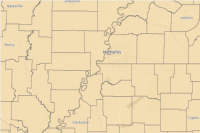

In [30]:
itm = gis.content.get('9859918e235f47ce90deff19bed75010')

itm

### View Item Layers

This Item references variety of Feature Layers we can use. In our case, we need the Counties, the layer referenced by the `2` index.

In [31]:
for lyr in itm.layers:
    print(lyr.properties.name, lyr.properties.id)

USA_Country 0
USA_State 1
USA_County 2
USA_ZipCode 3
USA_Tract 4
USA_BlockGroup 5


### Create a Layer Object Instance

Using the correct index, we can retrieve the Counties as a [FeatureLayer](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#featurelayer), the object enabling access to the underlying data.

In [32]:
lyr = itm.layers[2]

lyr

<FeatureLayer url:"https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Boundaries_2021/FeatureServer/2">

### Retrieve Data Using a Query

Through the layer, we can [query](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.FeatureLayer.query) to retrieve the data as a [FeatureSet](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#featureset). Using function chaining, we can immediately convert this to a [Spatially Enabled DataFrame](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/) using the `sdf` property of the `FeatureSet`.

In [33]:
lyr_df = lyr.query(out_fields=['FIPS'], out_sr=4326).sdf

lyr_df.info()
lyr_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  3143 non-null   Int64   
 1   FIPS      3143 non-null   string  
 2   SHAPE     3143 non-null   geometry
dtypes: Int64(1), geometry(1), string(1)
memory usage: 76.9 KB


,OBJECTID,FIPS,SHAPE
0,1,01001,"{""rings"": [[[-86.413120727, 32.7073921370001],..."
1,2,01003,"{""rings"": [[[-87.5649079999999, 30.281622], [-..."
2,3,01005,"{""rings"": [[[-85.257838372, 32.147937056], [-8..."
3,4,01007,"{""rings"": [[[-87.06574294, 33.2469132270001], ..."
4,5,01009,"{""rings"": [[[-86.453024823, 34.259323463], [-8..."


### Combine Geometry and Custom Data

Using a join, we can now combine our custom data with the percent columns and the compsite index describing economic distress with the geometries retrieved above to create a new Spatially Enabled DataFrame.

In [34]:
df_geo = df.join(lyr_df[['FIPS', 'SHAPE']].set_index('FIPS'), on='FIPS', how='right')
df_geo.spatial.set_geometry('SHAPE')

df_geo.info()
df_geo.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   NAME                       3143 non-null   object  
 1   GEO_ID                     3143 non-null   object  
 2   state                      3143 non-null   object  
 3   county                     3143 non-null   object  
 4   pct_less_than_30K          3143 non-null   float64 
 5   pct_less_than_high_school  3143 non-null   float64 
 6   pct_below_poverty          3143 non-null   float64 
 7   pct_with_SNAP              3143 non-null   float64 
 8   pct_with_SSI               3143 non-null   float64 
 9   FIPS                       3143 non-null   object  
 10  composite_index            3143 non-null   float64 
 11  SHAPE                      3143 non-null   geometry
dtypes: float64(6), geometry(1), object(5)
memory usage: 319.2+ KB


,NAME,GEO_ID,state,county,pct_less_than_30K,pct_less_than_high_school,pct_below_poverty,pct_with_SNAP,pct_with_SSI,FIPS,composite_index,SHAPE
0,"Autauga County, Alabama",0500000US01001,01,001,0.260706,0.895845,0.135785,0.107980,0.060624,01001,0.339408,"{""rings"": [[[-86.413120727, 32.7073921370001],..."
1,"Baldwin County, Alabama",0500000US01003,01,003,0.206147,0.910142,0.092049,0.071281,0.045957,01003,0.296099,"{""rings"": [[[-87.5649079999999, 30.281622], [-..."
2,"Barbour County, Alabama",0500000US01005,01,005,0.438050,0.756710,0.264719,0.259793,0.105964,01005,0.462266,"{""rings"": [[[-85.257838372, 32.147937056], [-8..."
3,"Bibb County, Alabama",0500000US01007,01,007,0.305520,0.805381,0.169429,0.179585,0.067768,01007,0.365206,"{""rings"": [[[-87.06574294, 33.2469132270001], ..."
4,"Blount County, Alabama",0500000US01009,01,009,0.275023,0.836481,0.132366,0.109061,0.087418,01009,0.342828,"{""rings"": [[[-86.453024823, 34.259323463], [-8..."


## Share for Mapping

To enable further exploration and sharing, we now can share this to our organization on ArcGIS Online were we can take advantage of [Smart Mapping](https://storymaps.arcgis.com/collections/9dd9f03ac2554da4af78b42020fb40c1?item=1), [Instant Apps](https://www.esri.com/en-us/arcgis/products/arcgis-instant-apps/overview) and [ArcGIS Dashboards](https://www.esri.com/en-us/arcgis/products/arcgis-dashboards/overview) to share insights derived from this data.

If, however, you want to save the data locally to use with ArcGIS Pro for further analysis, you can also easily convert this Spatiall Enabled Dataframe to a feature class using the [to_featureclass](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.to_featureclass) method.

In [35]:
fl = df_geo.spatial.to_featurelayer('Economic_Index', gis)

fl

<Item title:"Economic_Index" type:Feature Layer Collection owner:jmccune_bateam>